# Лабораторная работа 3: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [1]:
#!pip install cvxopt

In [2]:
import numpy as np
from cvxopt import matrix
from cvxopt import solvers
from sklearn.datasets import make_classification, make_moons, make_circles
import matplotlib.pyplot as plt

In [3]:
solvers.options['show_progress'] = False

Все условия

In [4]:
P = matrix(np.diag([2., 8.]), tc='d')
q = matrix(np.array([-8., -16.]), tc='d')
G = matrix(np.array([[1., 1.], [1., 0.], [-1., 0.], [0., -1.]]),  tc='d')
h = matrix(np.array([5., 3., 0., 0.]),  tc='d')

sol = solvers.qp(P, q, G, h)
print(sol['x'])

[ 3.00e+00]
[ 2.00e+00]



без х1 + х2 <= 5

In [5]:
P = matrix(np.diag([2., 8.]), tc='d')
q = matrix(np.array([-8., -16.]), tc='d')
G = matrix(np.array([[1., 0.], [-1., 0.], [0., -1.]]),  tc='d')
h = matrix(np.array([3., 0., 0.]),  tc='d')

sol = solvers.qp(P, q, G, h)
print(sol['x'])

[ 3.00e+00]
[ 2.00e+00]



без х1 <= 3

In [6]:
P = matrix(np.diag([2., 8.]), tc='d')
q = matrix(np.array([-8., -16.]), tc='d')
G = matrix(np.array([[1., 1.], [-1., 0.], [0., -1.]]),  tc='d')
h = matrix(np.array([5., 0., 0.]),  tc='d')

sol = solvers.qp(P, q, G, h)
print(sol['x'])

[ 3.20e+00]
[ 1.80e+00]



без -х1 <= 0

In [7]:
P = matrix(np.diag([2., 8.]), tc='d')
q = matrix(np.array([-8., -16.]), tc='d')
G = matrix(np.array([[1., 1.], [1., 0.], [0., -1.]]),  tc='d')
h = matrix(np.array([5., 3., 0.]),  tc='d')

sol = solvers.qp(P, q, G, h)
print(sol['x'])

[ 3.00e+00]
[ 2.00e+00]



без -х2 <= 0

In [8]:
P = matrix(np.diag([2., 8.]), tc='d')
q = matrix(np.array([-8., -16.]), tc='d')
G = matrix(np.array([[1., 1.], [1., 0.], [-1., 0.]]),  tc='d')
h = matrix(np.array([5., 3., 0.]),  tc='d')

sol = solvers.qp(P, q, G, h)
print(sol['x'])

[ 3.00e+00]
[ 2.00e+00]



**Ответ** все условия, кроме x1 <= 3 можно убрать

## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

In [47]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C=1, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        if self.transform:
            X = self.transform(X)
        M, n = X.shape
        P = np.zeros((n + 1 + M, n + 1 + M))
        P[:n,:n] = np.eye(n)
        q = np.hstack(([0.]*(n + 1), [self.C]*M))
        G1 = np.hstack((-y[:,None]*X, -y[:,None], -np.eye(M)))
        G2 = np.hstack((np.zeros((M, n + 1)), -np.eye(M)))
        G = np.vstack((G1, G2))
        h = np.hstack(([-1.]*M, [0.]*M))
        
        sol = solvers.qp(matrix(P, tc='d'), matrix(q, tc='d'), matrix(G,  tc='d'), matrix(h,  tc='d'))
        self.w = np.array(sol['x'][:n]).flatten()
        self.b = float(np.array(sol['x'][n:n+1]))
        self.ksi = np.array(sol['x'][n+1:]).flatten()
        
        self.sup_vect = []
        self.sup_vect_class = []
        for i in range(M):
            if (np.absolute(y[i] * (self.w.T.dot(X[i]) + self.b) - 1) < 0.000006) or (self.ksi[i] > 0.000006):
                self.sup_vect.append(X[i])
                self.sup_vect_class.append(y[i])
        self.sup_vect = np.array(self.sup_vect)
        self.sup_vect_class = np.array(self.sup_vect_class)
        
    def predict_proba(self, X):
        if self.transform:
            X = self.transform(X)
        return (np.dot(X, self.w) + self.b).flatten()
            
    def predict(self, X):
        return np.sign(self.predict_proba(X))

In [48]:
def paint(X, y, C, i, j, tr = None, svm = 'linear', kernel='linear', p=None, g=None):
    if svm == 'linear':
        model = LinearSVM(C, transform = tr)
        model.fit(X, y)
    else:
        model = DualSVM(C = C, kernel = kernel, p = p, g = g)
        model.fit(X, y)

    ax[j][i].scatter(X[:, 0], X[:, 1], s=60, c=y, cmap='autumn', edgecolor='black')
    ax[j][i].scatter(model.sup_vect[:, 0], model.sup_vect[:, 1], s=250, marker='+', 
                     c=model.sup_vect_class, cmap='spring')

    x1_min = np.min(X[:, 0]) - 1
    x1_max = np.max(X[:, 0]) + 1
    x2_min = np.min(X[:, 1]) - 1
    x2_max = np.max(X[:, 1]) + 1
    
    ax[j][i].set_xlim([x1_min, x1_max])
    ax[j][i].set_ylim([x2_min, x2_max])

    xvals = np.linspace(x1_min, x1_max, 100)
    yvals = np.linspace(x2_min, x2_max, 100)

    xx, yy = np.meshgrid(xvals, yvals)
    zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
    
    ax[j][i].pcolormesh(xx, yy, zz, cmap='plasma', zorder=0, shading='auto')
    ax[j][i].contour(xx, yy, zz, colors=["k", "w", "k"], linestyles=["--", "-", "--"], levels=[-1, 0.0001, 1])
    ax[j][i].set_xlabel(f'Опорных векторов: {len(model.sup_vect)}', fontsize = 13)    

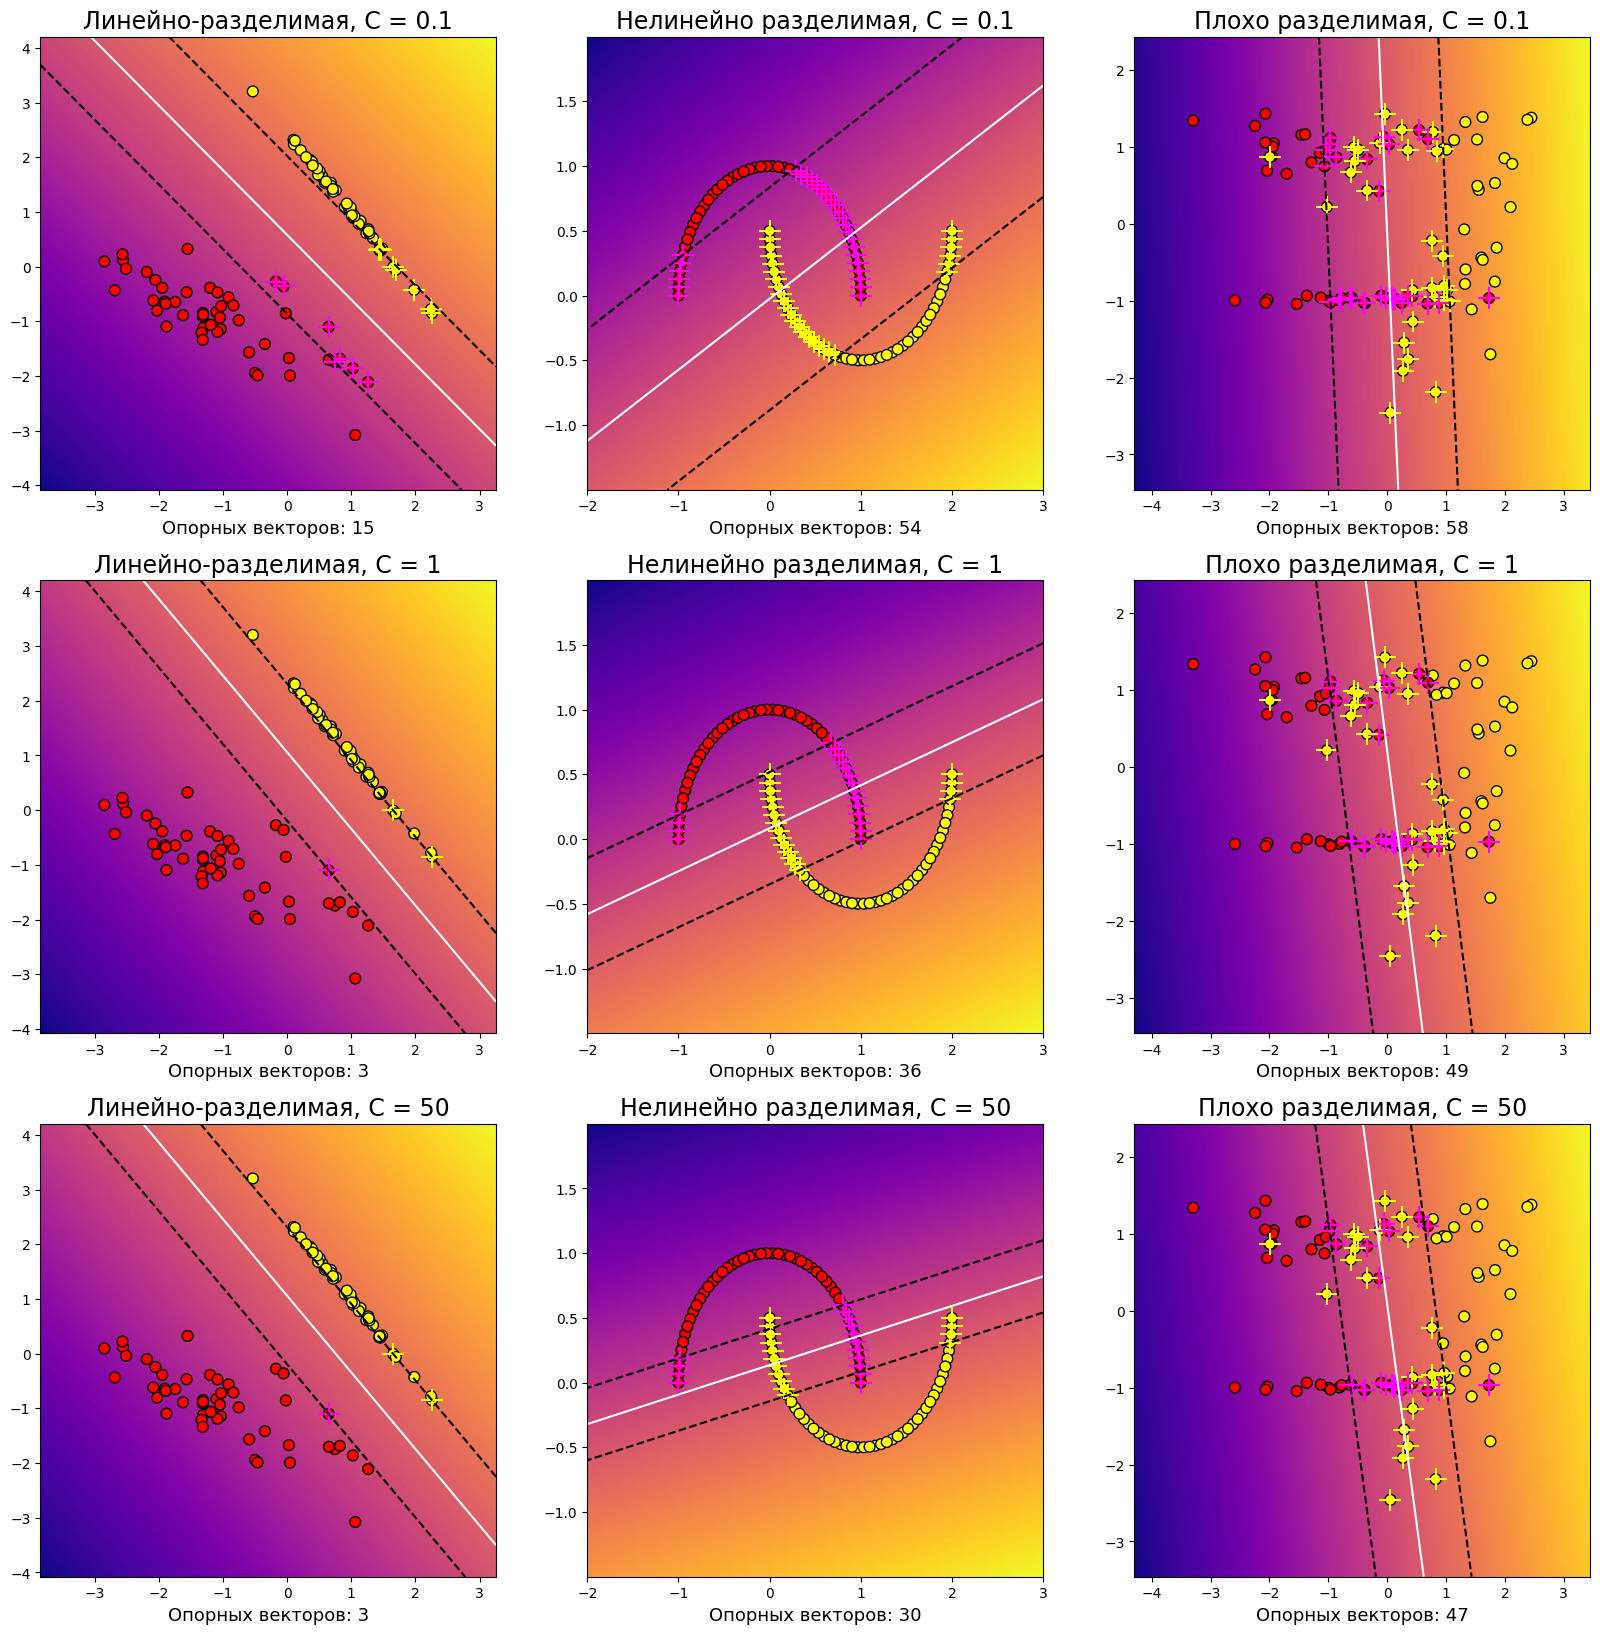

In [49]:
X = [[]]*3; y = [[]]*3
X[0], y[0] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=16)
X[1], y[1] = make_moons(n_samples=100, random_state = 35)
X[2], y[2] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=435)
X = np.array(X); y = np.array(y)
titles = ["Линейно-разделимая", "Нелинейно разделимая", "Плохо разделимая"]
C = [0.1, 1, 50]

fig, ax = plt.subplots(len(C), 3, figsize=(20,20))
for i in range(3):
    y[i][y[i] == 0] = -1
    for j in range(len(C)):
        paint(X[i], y[i], C[j], i, j)
        ax[j][i].set_title(f'{titles[i]}, C = {C[j]}', fontsize = 17)

**Ответ:** C ростом C уменьшается число опорных векторов

С преобразованием координат

In [50]:
from sklearn.preprocessing import PolynomialFeatures
def square_transform(X):
    '''
    f(x_1, ..., x_d) = (x_1, ... x_d, x_1^2, x_1x_2, ..., x_d^2)
    '''
    poly = PolynomialFeatures(3)
    X_new = poly.fit_transform(X)
    X_new = X_new[:,1:]
    
    return X_new

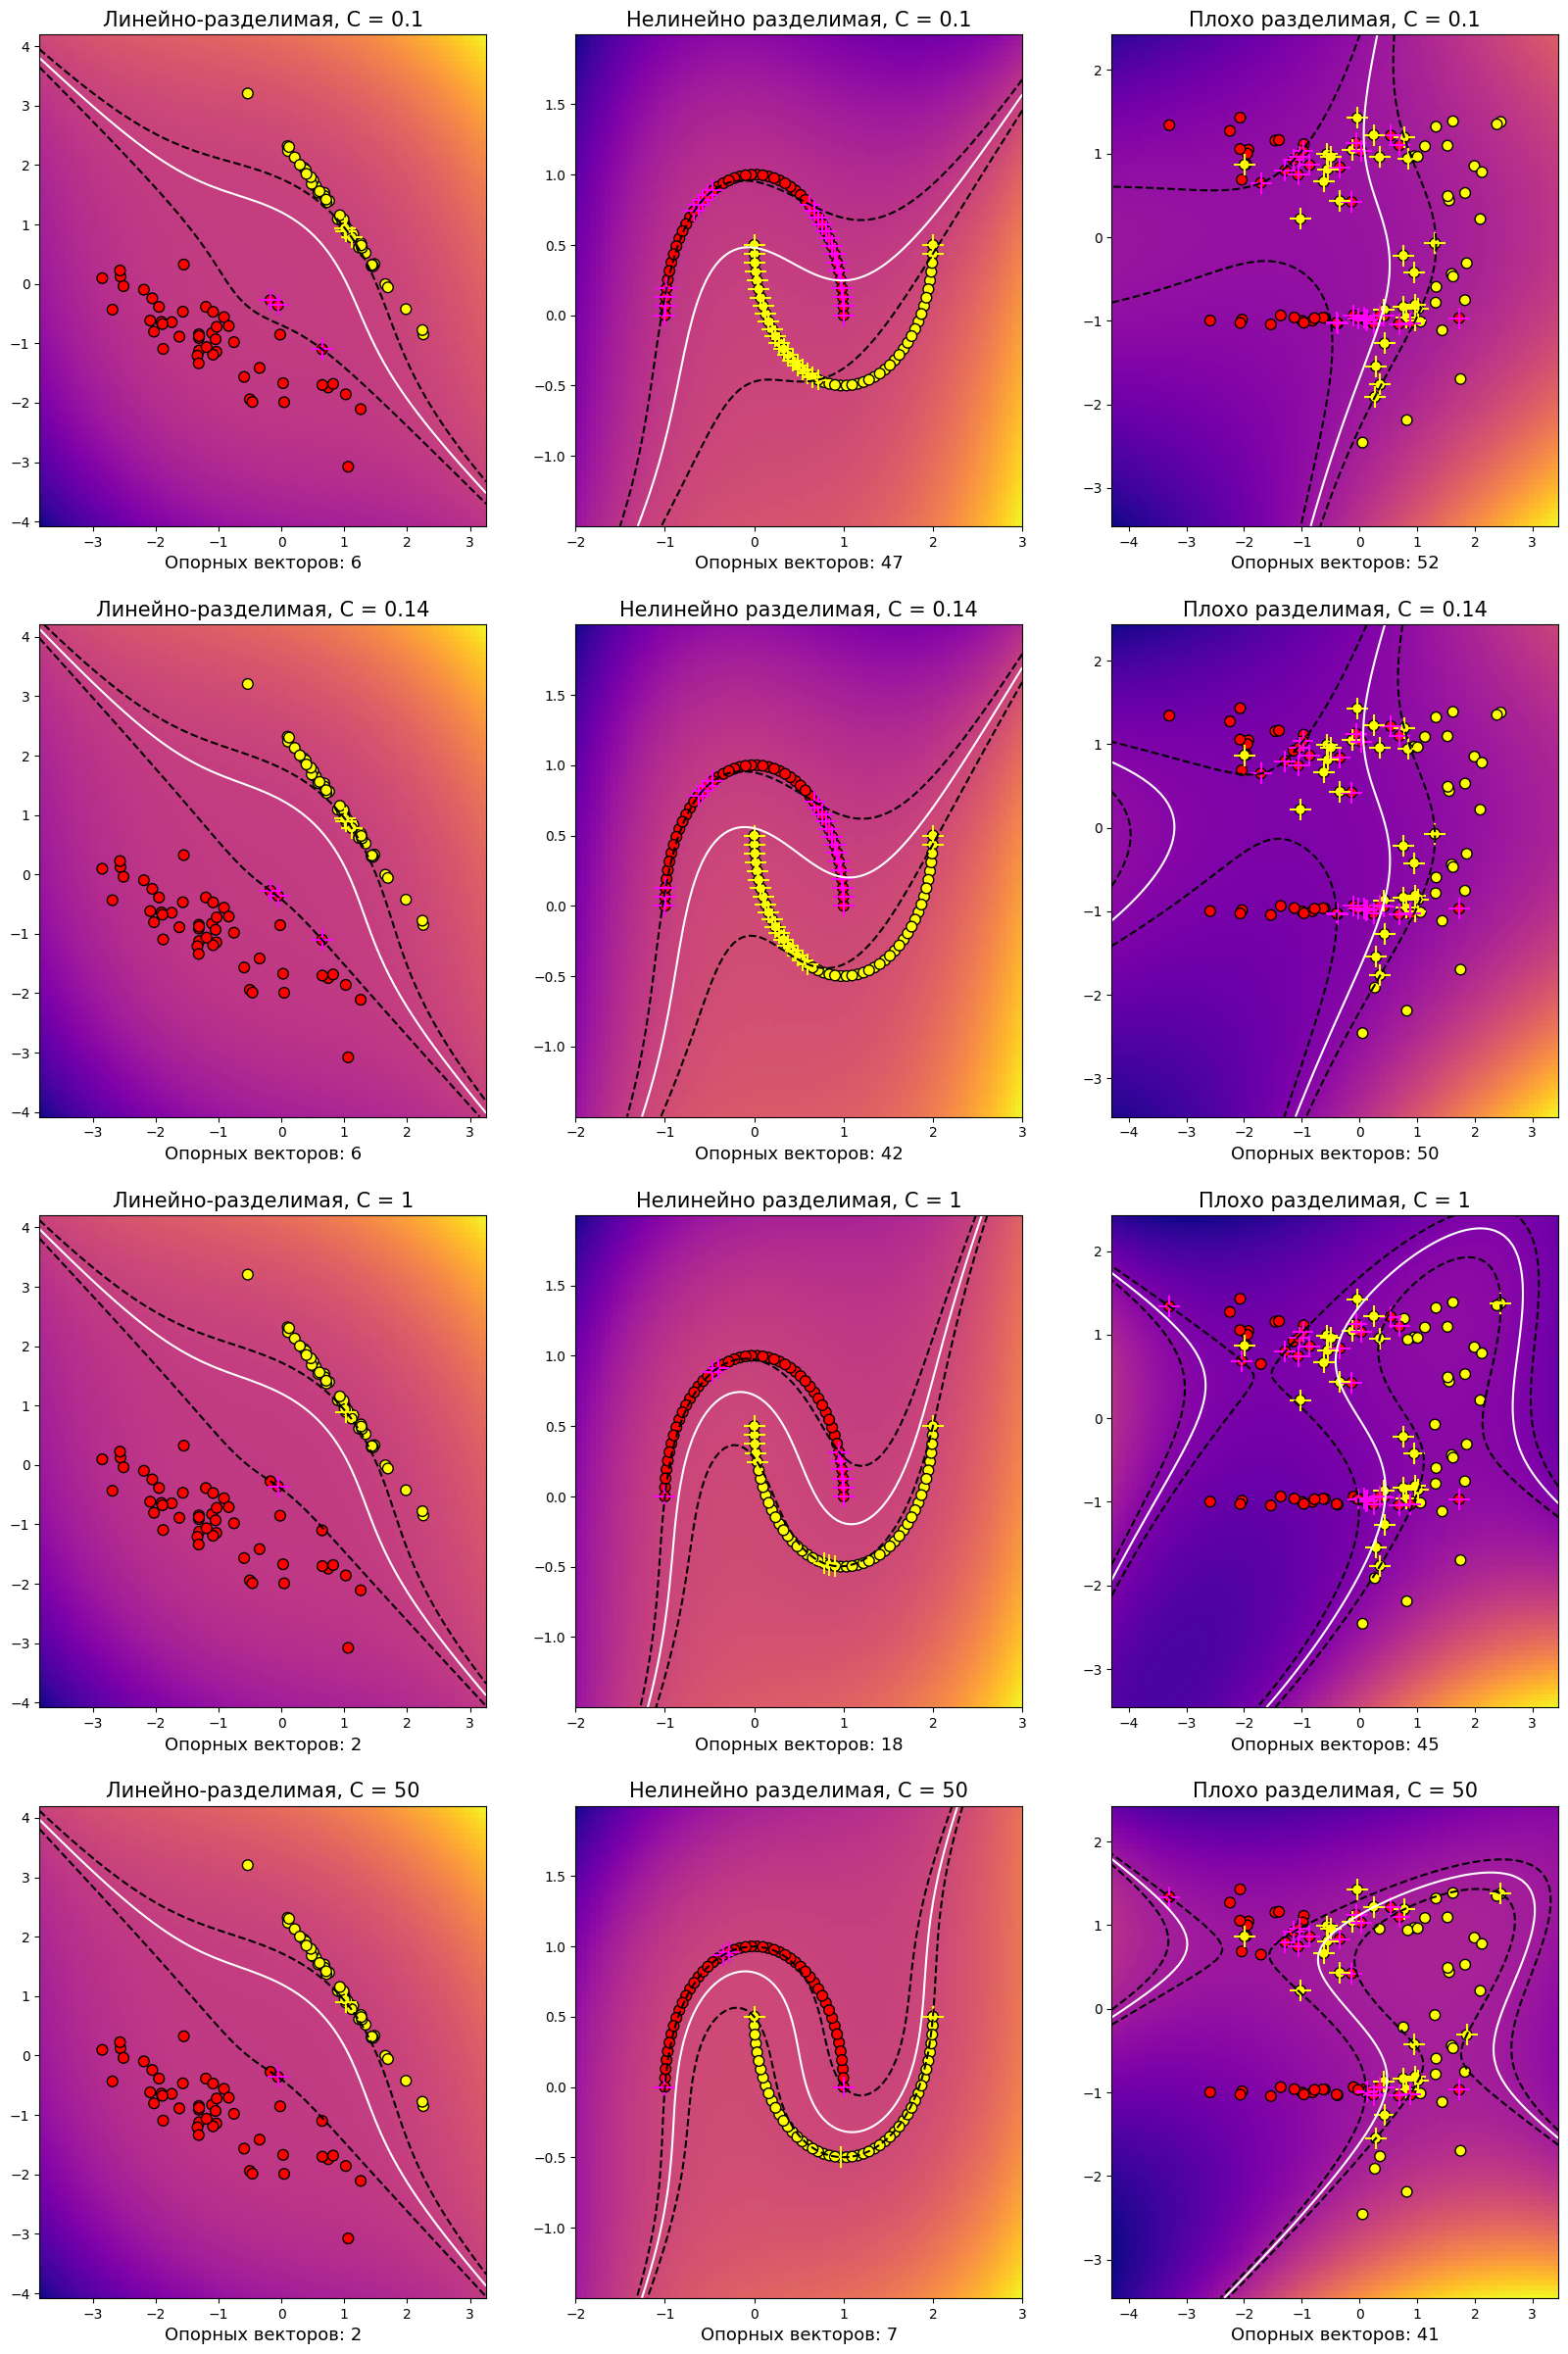

In [51]:
C = [0.1, 0.14, 1, 50]

fig, ax = plt.subplots(len(C), 3, figsize=(20,30))
for i in range(3):
    y[i][y[i] == 0] = -1
    for j in range(len(C)):
        paint(X[i], y[i], C[j], i, j, tr = square_transform)
        ax[j][i].set_title(f'{titles[i]}, C = {C[j]}', fontsize = 15)

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

In [52]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    
    def __init__(self, C=1, kernel="linear", p=None, g=None):
        self.C = C
        self.kernel = kernel
        self.p = p
        self.g = g
        
    def _linear(self, x1, x2):
        return np.dot(x1, x2)
    
    def _poly(self, x1, x2, p):
        return (np.dot(x1, x2) + 1) ** p
        
    def _rbf(self, x1, x2, g):
        nr = np.linalg.norm(x1 - x2) ** 2
        return np.exp((-1/(2*g)) * nr)
    
    def fit(self, X, y):
        M, n = X.shape
        K = np.zeros((M, M))
        for i in range(M):
            for j in range(M):
                if self.kernel == "linear": 
                    K[i, j] = self._linear(X[i], X[j])
                elif self.kernel == "poly": 
                    K[i, j] = self._poly(X[i], X[j], self.p)
                else: 
                    K[i, j] = self._rbf(X[i], X[j], self.g)
        
        P = matrix(np.outer(y, y) * K, tc='d')
        q = matrix(-np.ones(M), tc='d')
        G = matrix(np.vstack((np.eye(M), -np.eye(M))), tc='d')
        h = matrix(np.hstack((self.C * np.ones(M), np.zeros(M))), tc='d')
        A = matrix(y.reshape(1, M), tc='d')  
        b = matrix(0, tc='d')                   
        sol = solvers.qp(P, q, G, h, A, b)
        self.alpha = np.array(sol['x']).flatten()
        
        index = self.alpha > 0.000006
        self.sup_alpha = self.alpha[index]
        self.sup_vect = X[index]
        self.sup_vect_class = y[index]
        
        self.b = []
        for i in range(len(self.sup_vect)):
            temp = 0
            for j in range(len(self.sup_vect)):
                if self.kernel == "linear": 
                    temp += self._linear(self.sup_vect[i], self.sup_vect[j])
                elif self.kernel == "poly": 
                    temp += self._poly(self.sup_vect[i], self.sup_vect[j], self.p)
                else: 
                    temp += self._rbf(self.sup_vect[i], self.sup_vect[j], self.g)
            self.b.append(self.sup_vect_class[i] - self.sup_alpha[i]*self.sup_vect_class[i]*temp)
        self.b = np.array(self.b).mean()
        
    def predict_proba(self, X):
        y_pred = []
        for item in X:
            prediction = 0
            for i in range(len(self.sup_alpha)):
                if self.kernel == "linear":
                    prediction += self.sup_alpha[i] * self.sup_vect_class[i] * self._linear(self.sup_vect[i], item)
                elif self.kernel == "poly":
                    prediction += self.sup_alpha[i] * self.sup_vect_class[i] * self._poly(self.sup_vect[i], item, self.p)
                else:
                    prediction += self.sup_alpha[i] * self.sup_vect_class[i] * self._rbf(self.sup_vect[i], item, self.g)
            prediction += self.b
            y_pred.append(prediction)
        return np.array(y_pred)        
            
    def predict(self, X):
        return np.sign(self.predict_proba(X))

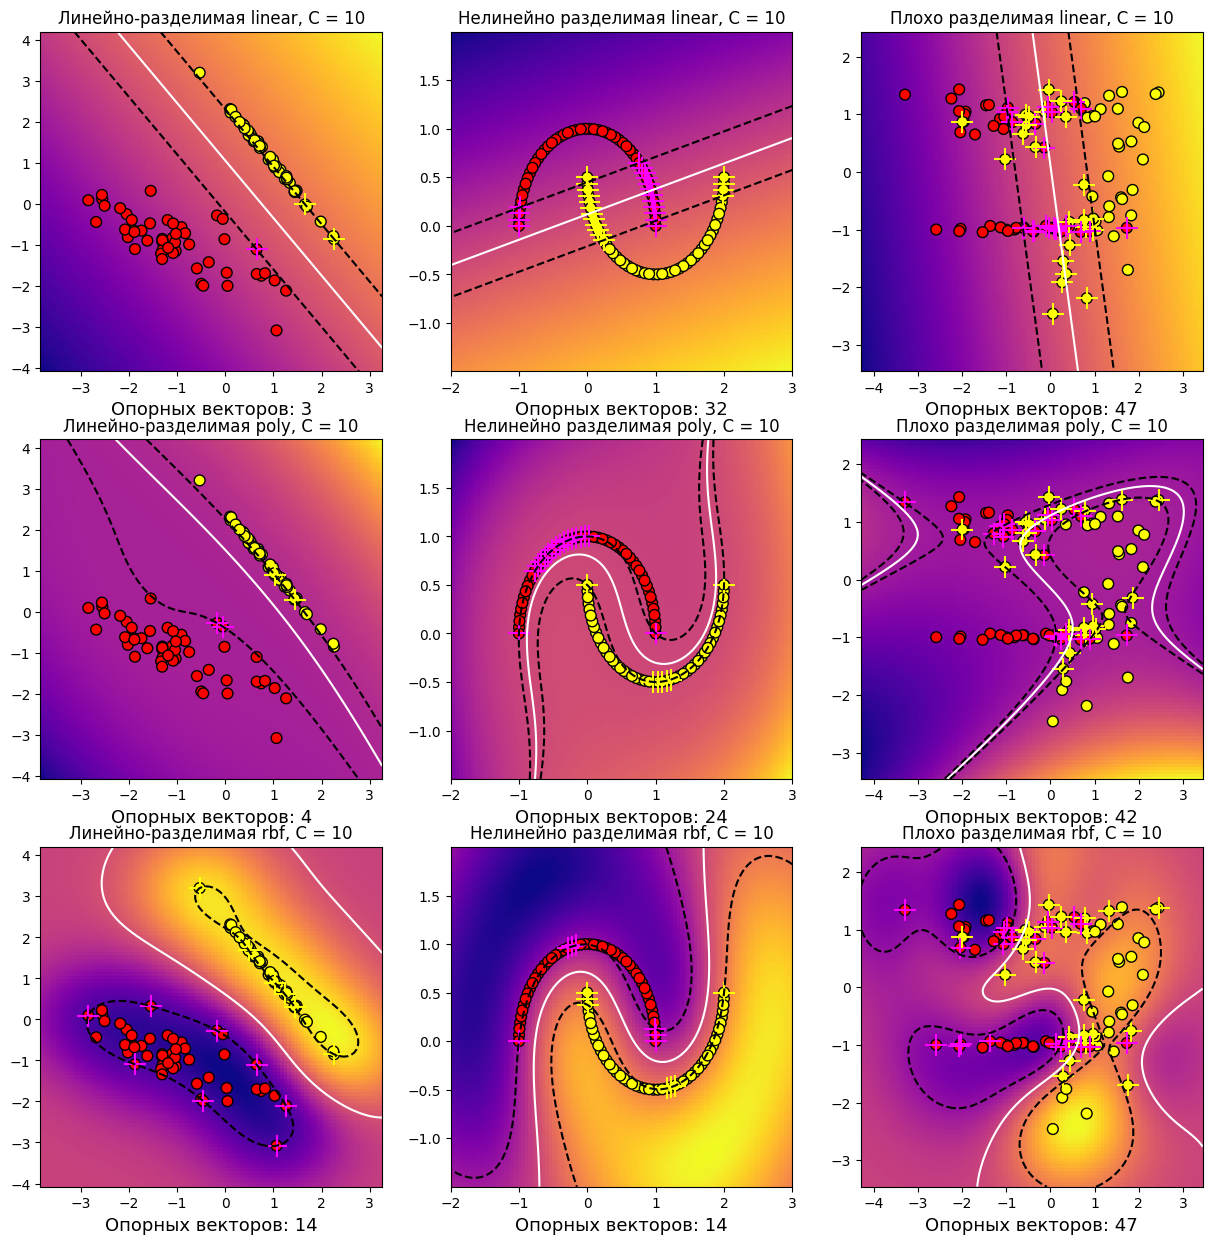

In [53]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
kernels = ['linear', 'poly', 'rbf']
for i in range(3):
    for j in range(3):
        paint(X[i], y[i], C = 10, i=i, j=j, svm = 'dual', kernel = kernels[j], p = 3, g = 1)
        ax[i][j].set_title(f'{titles[j]} {kernels[i]}, C = {10}')

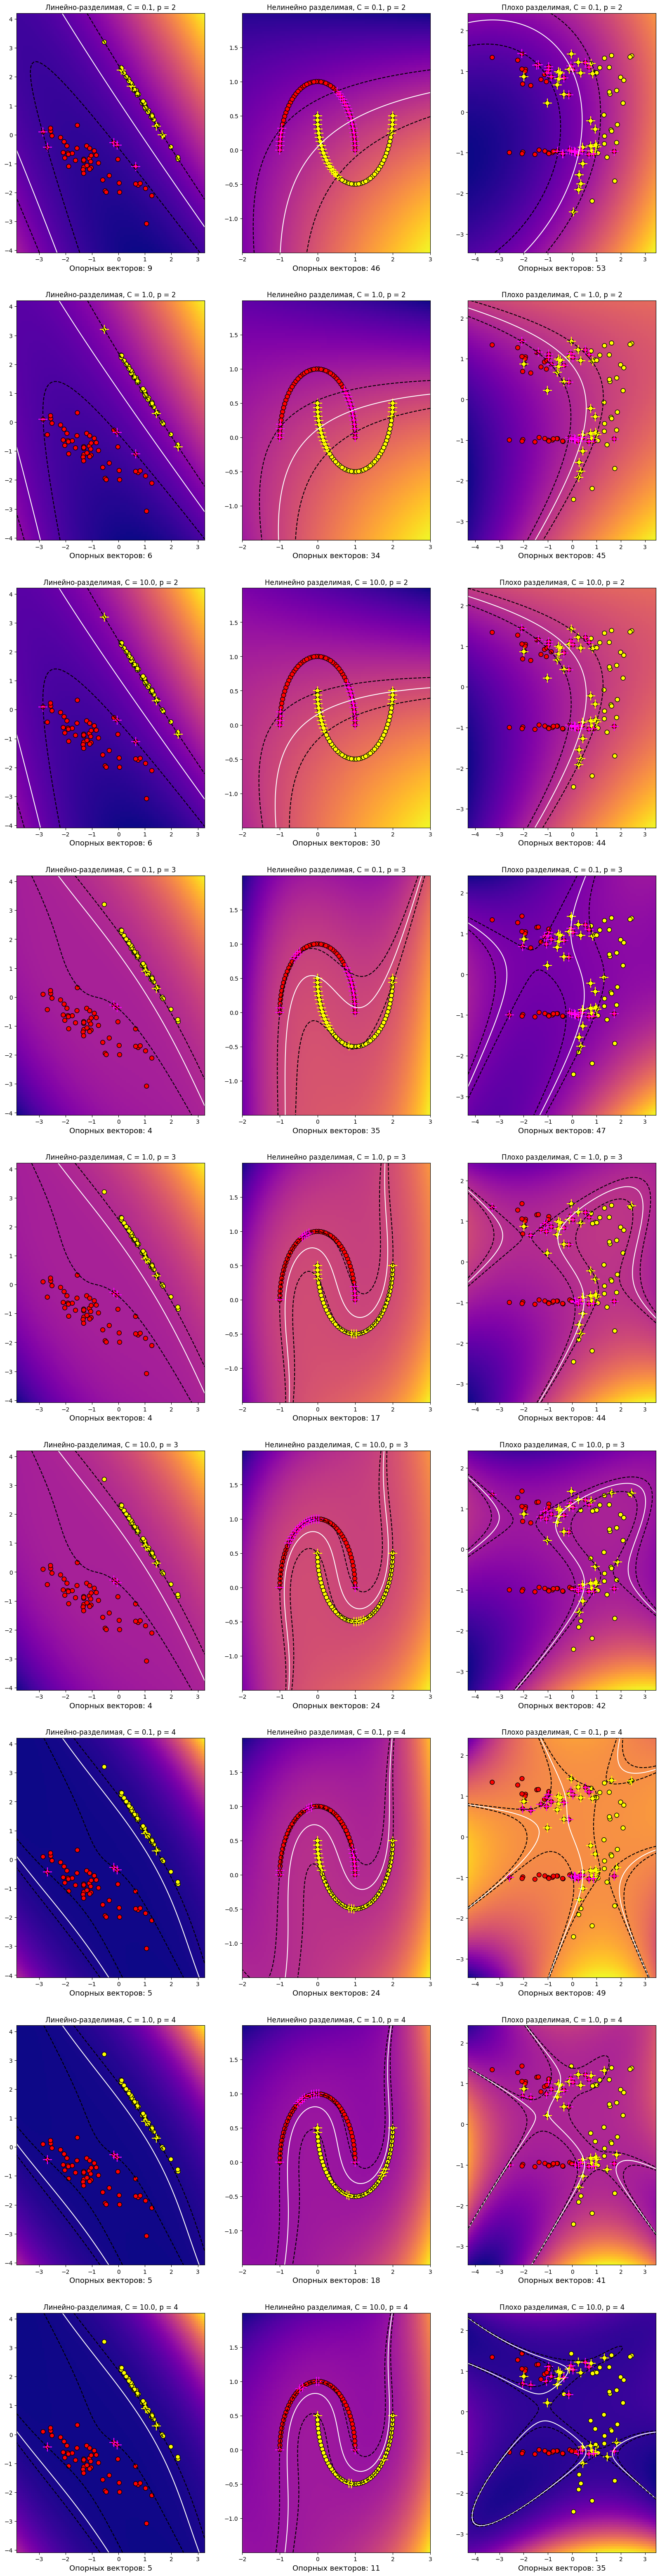

In [41]:
p = np.arange(2,5)
C = [0.1, 1, 10]
cvals, pvals = np.meshgrid(C, p)
pp = pvals.flatten()
cc = cvals.flatten()
fig, ax = plt.subplots(len(pp), 3, figsize=(20,80))
for i in range(3):
    for j in range(len(pp)):
        paint(X[i], y[i], cc[j], i, j, svm = 'dual', kernel = 'poly', p = pp[j])
        ax[j][i].set_title(titles[i] + ', C = ' + str(cc[j]) + ', p = ' + str(pp[j]))

**Ответ:** при повышении степени полинома границы классов строятся лучше. С влияет на ширину полосы.

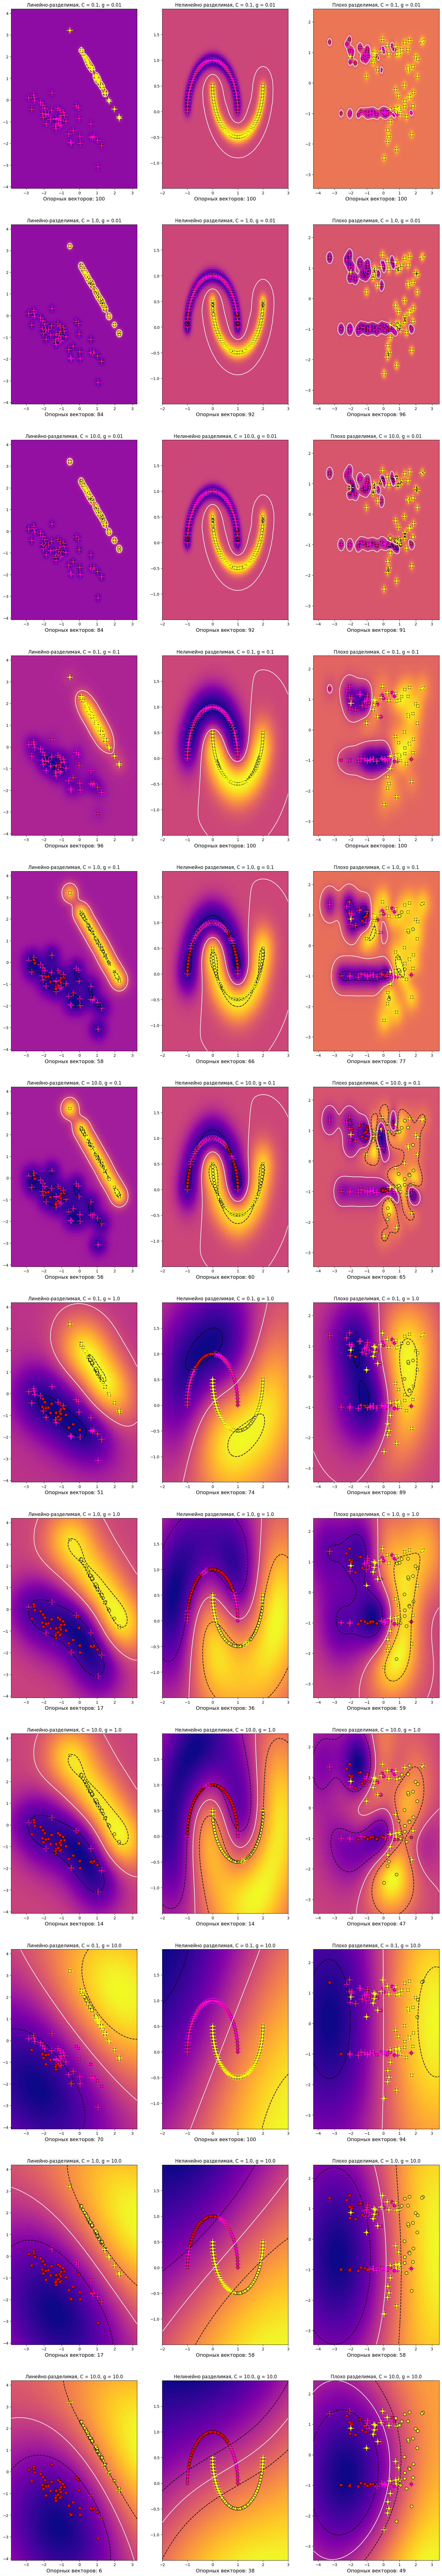

In [42]:
g = [0.01, 0.1, 1, 10]
cvals, gvals = np.meshgrid(C, g)
gg = gvals.flatten()
cc = cvals.flatten()
fig, ax = plt.subplots(len(gg), 3, figsize=(20,120))
for i in range(3):
    for j in range(len(gg)):
        paint(X[i], y[i], cc[j], i, j, svm = 'dual', kernel = 'rbf', g = gg[j])
        ax[j][i].set_title(titles[i] + ', C = ' + str(cc[j]) + ', g = ' + str(gg[j]))

**Ответ:** cлишком малое C ведёт к грубой модели, слишком малое гамма - к переобучению.